In [1]:
from src.vnc import run_vnc_simulation

%load_ext autoreload
%autoreload 1

from src.plot_utils import *
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
from pathlib import Path
from hydra import initialize, compose

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Use GPU 0
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"




In [2]:
initialize(config_path="../configs", version_base=None)


hydra.initialize()

In [3]:
# Compose the config
cfg = compose(config_name="config")

# Set the current working directory to the cwd_dir specified in the config
cfg.paths.cwd_dir = Path.cwd()

# Create directories specified in the config if they do not exist
for k in cfg.paths.keys():
    if k != 'user':
        cfg.paths[k] = Path(cfg.paths[k])
        cfg.paths[k].mkdir(parents=True, exist_ok=True)
        

In [4]:
cfg.experiment.stimNeurons

[31, 132]

In [5]:
cfg.experiment.seed

[5597, 6559, 4470, 2578, 2633, 185, 2487, 5789, 7318, 4162]

In [6]:
results = run_vnc_simulation(cfg)

/home/dsamy/research/bdn2cpg/src/vnc.py:374: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  stim_neurons = jnp.array(cfg.experiment.stimNeurons, dtype=jnp.int64)
/home/dsamy/research/bdn2cpg/src/sim_utils.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sizes[sizes.isna()] = normSize
/home/dsamy/research/bdn2cpg/src/sim_utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

Running simulation without shuffle or noise


11.367911


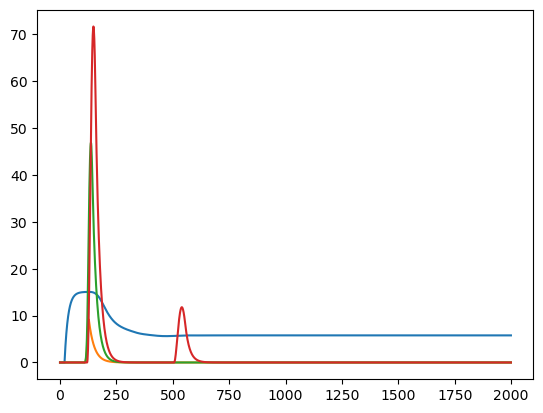

In [15]:
R = results[8]


wTable = pd.read_csv("../data/manc t1 connectome data/wTable_20231020_DNtoMN_unsorted_withModules.csv",index_col=0)
nonMns = wTable.loc[(wTable["bodyId"]==10093) | (wTable["bodyId"]==10707) | (wTable["bodyId"]==13905) | (wTable["bodyId"]==11751)]
mnIdxs = wTable.loc[wTable["class"]=="motor neuron"].index


for i in nonMns.index:
    plt.plot(R[i])
    #plt.plot(Rtsp[i])

print(np.mean(R))
